# Neural Network training

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from scipy.optimize import minimize
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

### Penguins dataset

The Penguins dataset is a popular dataset in the data science community that contains information on the size, sex, and species of penguins.

The dataset consists of 344 observations collected from 3 islands in the Palmer Archipelago, Antarctica. It includes the following 7 variables:
* species: The species of penguin (Adelie, Chinstrap, or Gentoo).
* island: The island where the penguin was observed (Biscoe, Dream, or Torgersen).
* bill_length_mm: The length of the penguin's bill in millimeters.
* bill_depth_mm: The depth of the penguin's bill in millimeters.
* flipper_length_mm: The length of the penguin's flipper in millimeters.
* body_mass_g: The mass of the penguin's body in grams.
* sex: The sex of the penguin (male or female).

In [2]:
# Load the Penguins dataset
penguins = sns.load_dataset('penguins')
penguins = penguins.dropna()
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male


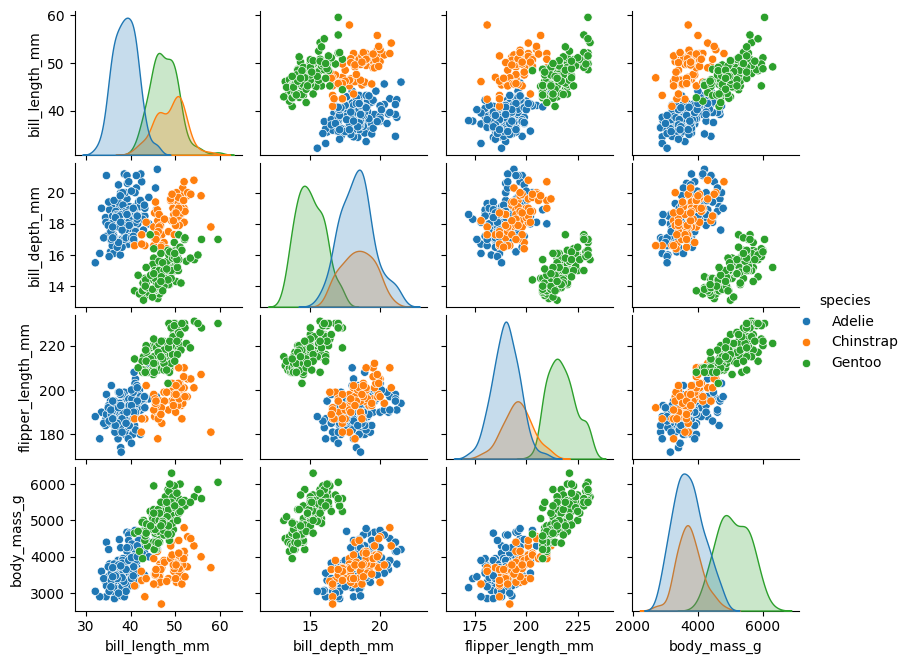

In [3]:
pairplot_figure = sns.pairplot(penguins, hue="species")
pairplot_figure.fig.set_size_inches(9, 6.5)

### Data peperation

In [4]:
X = penguins[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']].to_numpy()
y = penguins['species'].to_numpy()

# Standardize features (mean=0, std=1)
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Encode target labels (string -> int)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
target_names = label_encoder.classes_

# Neural network architecture

### Define Neural Network structure

In [5]:
n_inputs = X.shape[1]
n_hidden = 10
n_classes = len(np.unique(y))
num_samples = X.shape[0]

# Initialize weights randomly
np.random.seed(42)
params0 = np.random.randn((n_inputs * n_hidden) + n_hidden + (n_hidden * n_classes) + n_classes) * 0.01

### Define forward propagation and loss

In [6]:
def logits_function(p):
    # Roll back parameters
    W1 = p[0: n_inputs * n_hidden].reshape((n_inputs, n_hidden))
    b1 = p[n_inputs * n_hidden: (n_inputs + 1) * n_hidden]
    W2 = p[(n_inputs + 1) * n_hidden: (n_inputs + 1) * n_hidden + n_hidden * n_classes].reshape((n_hidden, n_classes))
    b2 = p[-n_classes:]

    # Forward pass
    z1 = X.dot(W1) + b1
    a1 = np.tanh(z1)
    logits = a1.dot(W2) + b2
    return logits

def forward_prop(p):
    logits = logits_function(p)
    exp_scores = np.exp(logits - np.max(logits, axis=1, keepdims=True))  # for numerical stability
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    correct_logprobs = -np.log(probs[range(num_samples), y])
    loss = np.mean(correct_logprobs)
    return loss

### Train using gradient descent variant "L-BFGS-B" from SciPy

In [7]:
print("Training neural network using scipy.optimize.minimize ...")

res = minimize(
    fun=forward_prop,
    x0=params0,
    method='L-BFGS-B',
    jac=False,
    options={'maxiter': 500},
    callback=lambda xk: None,  # optional: can print progress
)

best_params = res.x
print("\nOptimization done!")
print(f"Final loss: {res.fun:.4f}")

Training neural network using scipy.optimize.minimize ...

Optimization done!
Final loss: 0.0000


### Train and show the training loss progress

Iter   10 | Loss = 0.016993
Iter   20 | Loss = 0.000026

Optimization done!
Final loss: 0.0000


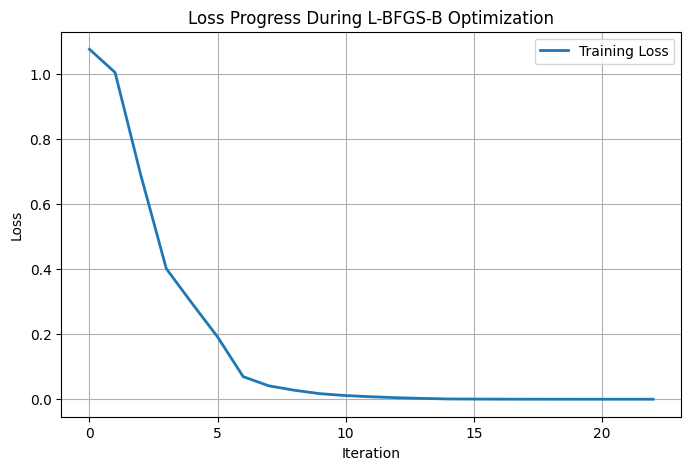

In [ ]:
# Initialize a list to record loss values
loss_history = []

# Define callback function to track loss progress
def record_loss(params):
    loss = forward_prop(params)
    loss_history.append(loss)
    # Print every 10 iterations
    if len(loss_history) % 10 == 0:
        print(f"Iter {len(loss_history):4d} | Loss = {loss:.6f}")

# Perform minimization (no 'verbose' option)
res = minimize(
    fun=forward_prop,
    x0=params0,
    method='L-BFGS-B',
    jac=False,
    options={'maxiter': 500},  
    callback=record_loss
)

best_params = res.x
print("\nOptimization done!")
print(f"Final loss: {res.fun:.4f}")

# ==============================================
# Plot loss progression
# ==============================================
plt.figure(figsize=(8, 5))
plt.plot(loss_history, label='Training Loss', linewidth=2)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss Progress During L-BFGS-B Optimization')
plt.legend()
plt.grid(True)
plt.show()


### Define prediction function

In [8]:
def predict(params, X_data):
    # Roll back parameters
    W1 = params[0: n_inputs * n_hidden].reshape((n_inputs, n_hidden))
    b1 = params[n_inputs * n_hidden: (n_inputs + 1) * n_hidden]
    W2 = params[(n_inputs + 1) * n_hidden: (n_inputs + 1) * n_hidden + n_hidden * n_classes].reshape((n_hidden, n_classes))
    b2 = params[-n_classes:]

    # Forward pass
    z1 = X_data.dot(W1) + b1
    a1 = np.tanh(z1)
    logits = a1.dot(W2) + b2

    # Softmax
    exp_scores = np.exp(logits - np.max(logits, axis=1, keepdims=True))
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)


### Evaluate accuracy


Training Accuracy: 100.00%


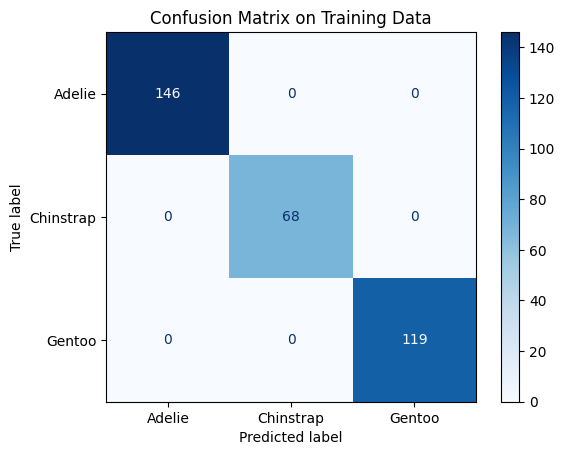

In [9]:
y_pred = predict(best_params, X)
acc = accuracy_score(y, y_pred)
print(f"\nTraining Accuracy: {acc * 100:.2f}%")

# Confusion matrix
cm = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix on Training Data")
plt.show()

### Show few predictions

In [10]:
pred_species = label_encoder.inverse_transform(y_pred)
print("\nSample predictions:")
for true, pred in list(zip(penguins['species'][:10], pred_species[:10])):
    print(f"True: {true:12s} | Predicted: {pred}")


Sample predictions:
True: Adelie       | Predicted: Adelie
True: Adelie       | Predicted: Adelie
True: Adelie       | Predicted: Adelie
True: Adelie       | Predicted: Adelie
True: Adelie       | Predicted: Adelie
True: Adelie       | Predicted: Adelie
True: Adelie       | Predicted: Adelie
True: Adelie       | Predicted: Adelie
True: Adelie       | Predicted: Adelie
True: Adelie       | Predicted: Adelie
